In [26]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

Time domain sampling: 2425


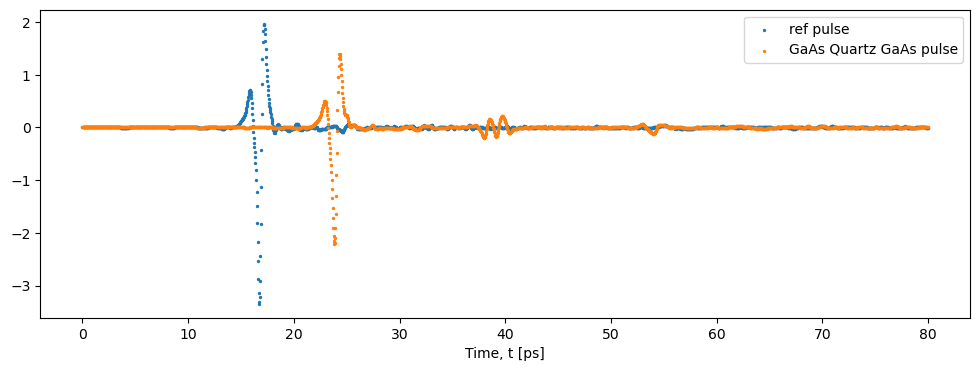

In [27]:
# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_06_02_2026\reference_15min_nitrogen.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_QREF = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_06_02_2026\QREF_129um_air_15min_nitrogen.txt",dtype=float)

t1= reference_pulse[:,0] + 740  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_QREF[:,0] + 740  # ADJUISTING THE AXIS
amp2 = sample_pulse_QREF[:,1]
time_axis_ref = t1
ref_pulse = amp1
time_axis_sample = t2
sample_pulse = amp2

#sample_pulse -= bias


L = len(ref_pulse)
print(f'Time domain sampling: {L}')


plt.figure(figsize=(12,4))
plt.scatter(time_axis_ref, ref_pulse, label='ref pulse', s=2)
plt.scatter(time_axis_sample, sample_pulse, label='GaAs Quartz GaAs pulse', s=2)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [28]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

In [29]:
## Check time steps are consistent in t_axis
# Compute time differences between consecutive samples
dt = np.diff(time_axis_ref)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

deltat = np.mean(dt)
deltat = deltat * 1e-12  # Convert to seconds for calculations

Time steps are uniform: False
Min dt: 0.03300329999990481
Max dt: 0.033003309999912744
Mean dt: 0.033003300330033


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - k ∈ (-0.002, 0.0)
Layer 1 - D ∈ (0.00097, 0.00103)
Layer 2 - D ∈ (8.999999999999999e-05, 0.00015)
Layer 3 - k ∈ (-0.002, 0.0)
Layer 3 - D ∈ (0.00097, 0.00103)
Bayes params: [((1.982-0.002j), 0.00103), ((1+0j), 8.999999999999999e-05), ((1.982-0.002j), 0.00103)]


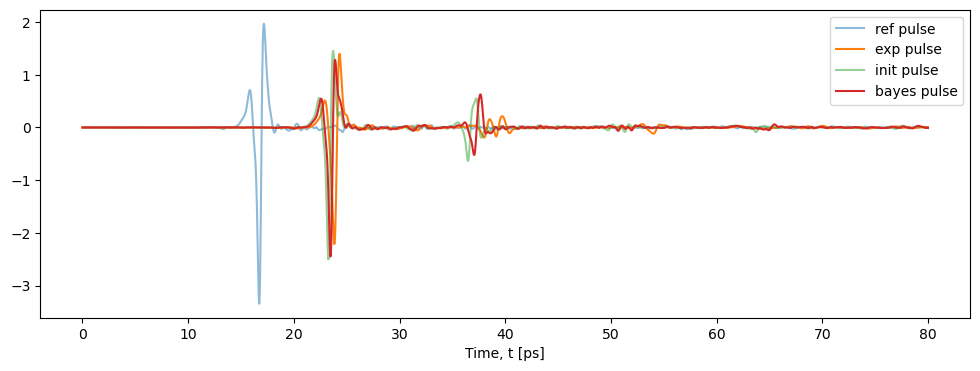

In [30]:
# Initial guesses
# Real thickness of air: d_real = 119 um

n_Qa = 1.982
k_Qa= -0.001
d_Qa = 100e-5
n_air = 1.0
k_air = 0.0
d_air = 120* 1e-6
n_Qb = 1.982
k_Qb = -0.001
d_Qb = 100e-5

optimize_mask = [
    (False, True, True),  # Qa
    (False, False, True),  # air
    (False, True, True)  # Qb
]

init_guess = [
   
    ((n_Qa + 1j*k_Qa), d_Qa),  # Qa
    ((n_air + 1j*k_air), d_air),  # air
    ((n_Qb + 1j*k_Qb), d_Qb),  # Qb
]

optimization_bounds = [0.3,0.001,30e-06]

# Convert ref to torch tensor 
ref_pulse_t = torch.tensor(ref_pulse, dtype=torch.float32) 
sample_pulse_t = torch.tensor(sample_pulse, dtype=torch.float32) 

init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess,  optimization_bounds=optimization_bounds,optimize_mask=optimize_mask)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, init_pulse, label='init pulse', alpha = 0.5)
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 5 parameters for 2000 iterations.
Iteration 99, Loss: 3.427896e-02, Layer 0: n=1.9820, k=-0.00619, D=1085.08 µm | Layer 1: n=1.0000, k=0.00000, D=34.51 µm | Layer 2: n=1.9820, k=-0.00619, D=1085.08 µm
Iteration 199, Loss: 3.089524e-02, Layer 0: n=1.9820, k=-0.00666, D=1085.71 µm | Layer 1: n=1.0000, k=0.00000, D=21.23 µm | Layer 2: n=1.9820, k=-0.00666, D=1085.71 µm
Iteration 299, Loss: 3.059245e-02, Layer 0: n=1.9820, k=-0.00679, D=1085.97 µm | Layer 1: n=1.0000, k=0.00000, D=17.92 µm | Layer 2: n=1.9820, k=-0.00679, D=1085.97 µm
Iteration 399, Loss: 3.054626e-02, Layer 0: n=1.9820, k=-0.00684, D=1086.08 µm | Layer 1: n=1.0000, k=0.00000, D=16.65 µm | Layer 2: n=1.9820, k=-0.00684, D=1086.08 µm
Iteration 499, Loss: 3.053870e-02, Layer 0: n=1.9820, k=-0.00687, D=1086.13 µm | Layer 1: n=1.0000, k=0.00000, D=16.13 µm | Layer 2: n=1.9820, k=-0.00687, D=1086.13 µm
Iteration 599, Loss: 3.053759e-02, Layer 0: n=1.9820, k=-0.00687, D=1086.15 µm | Layer 1: n=1.0000, k=0.00000, D=15

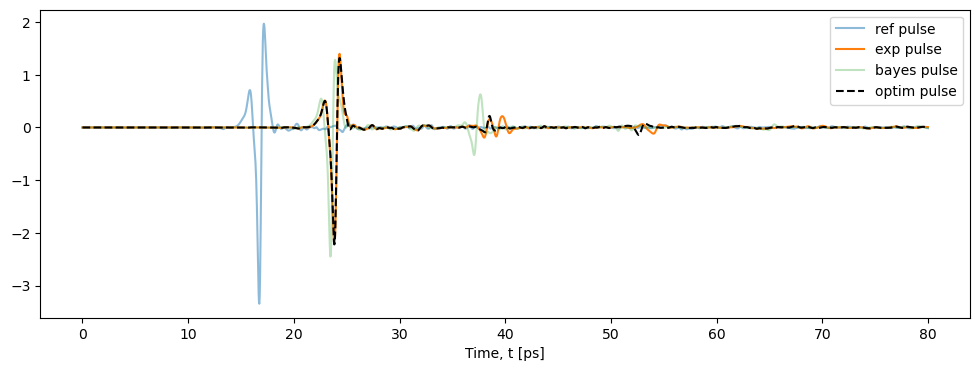

In [31]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.01)
optim_params = grad_optimizer.optimize(num_iterations=2000, updates=100, alpha=1)



optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse', alpha = 0.3)
plt.plot(time_axis_sample, optim_pulse, label='optim pulse',linestyle='--' ,color='black' )
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [32]:
optim_params

[((1.9819999933242798+0.00045103972661308944j), 0.0010925398673862219),
 ((1+0j), 1.6298074115184136e-05),
 ((1.9819999933242798-0.014167995192110538j), 0.0010794593254104257)]

In [33]:
# To print final paramers in a more readable format
for i, (n_complex, d) in enumerate(optim_params):   
    print(f"Layer {i+1}: n = {n_complex:.4f}, d = {d*1e6:.3f} um")
        

Layer 1: n = 1.9820+0.0005j, d = 1092.540 um
Layer 2: n = 1.0000+0.0000j, d = 16.298 um
Layer 3: n = 1.9820-0.0142j, d = 1079.459 um


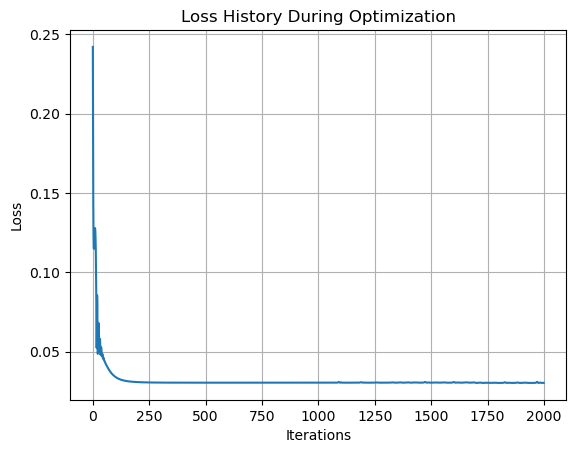

In [34]:
plt.plot(grad_optimizer.loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History During Optimization')
plt.grid(True)